In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy import stats
from IPython import display
import time
from matplotlib.patches import Rectangle
%matplotlib inline

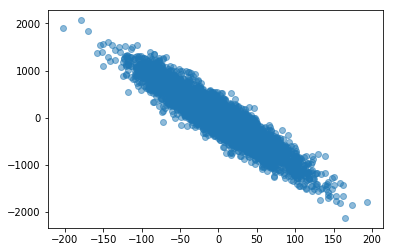

In [2]:
m = 5000
r = 50
I = 10

f = lambda x : -10*x + 3 + 100*np.random.normal(0,2,1)
x = np.random.normal(0, 50, m)
y = np.array([f(i) for i in x])
x = x.reshape((m,))
y = y.reshape((m,))
bias = np.ones(m)
X = np.vstack((bias,x)).T

#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.scatter(x,y,alpha=0.5)

After appending bias vector to $x$, we have $X = [\textbf{1}, x]$. 

We solve for the model $a = (X^T X)^\dagger X^T y$, and plot the original regression line.

In [3]:
def regression(X, y):
    pseudoinv = np.linalg.pinv(np.dot(X.T,X))
    a = np.dot(np.dot(pseudoinv,X.T),y)
    return a

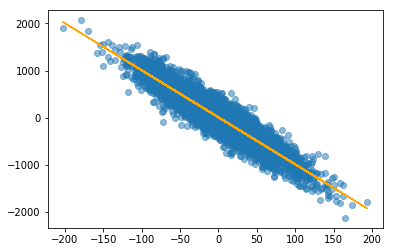

In [4]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#line = slope*x+intercept

a = regression(X,y)
line = a[1]*x + a[0] 
plt.scatter(x,y,alpha=0.5)
plt.plot(x, line, color="orange")
population_err = np.linalg.norm(y - np.dot(X,a))/len(X)

## Comparing Uniform and Importance Sampling of Rows of X

In [5]:
def generate_probabilities(X,y,a):
    errors = np.zeros(len(X))
    for idx,xi in enumerate(X):
        errors[idx] = (y[idx]- np.dot(xi,a))**2
    errors/sum(errors)


In [11]:
def sampled_regression(sampling, X, y, a, I, r):
    """
    arguments :
        sampling: 'uniform' or 'importance'
        X, y, a
        I: Iterations
        r: row sample size
        
        call example:
        sampled_regression(sampling='importance',X=X, y=y, a=a, I=10, r=10)
    """
    
    sample_errs = []
    min_err = float('inf')
    best_model = None
    probs = None
    
    for i in range(I):
        #plt.plot(x,line,color='red',alpha=0.5)
        if sampling.lower() == 'importance':
            idx = np.random.choice(range(len(X)), r, probs)
        else: # uniform
            idx = np.random.randint(len(X),size=r)
        X1 = X[idx,:]
        y1 = y[idx]
        if probs:
            y1 = y1/probs[idx]
        a1 = regression(X1,y1)
        err = np.linalg.norm(y - np.dot(X, a1))/len(X)
        
        sample_errs.append(err)
        if err < min_err:
            best_model = a1
            min_err = err
            probs = generate_probabilities(X,y,best_model)
            
        """
        #plotting stuff
        plt.title("Pupulation Error: "+str(population_err))
        pylab.xlim([-20,20])
        pylab.ylim([-250,250])
        plt.scatter(X1[:,1],y1,alpha=0.5,color="blue")
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        plt.legend([extra],['sample error: '+str(err)])
        x1 = X1[:,1]
        line1 = a1[0] + x*a1[1]
        plt.plot(x,line1,color='orange')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    
        #time.sleep(0)
        #plt.clf()
        """
    return sample_errs



In [19]:
imp_err = sampled_regression('importance', X,y,a,I,r)


In [20]:
unif_err = sampled_regression('uniform', X,y,a,I,r)

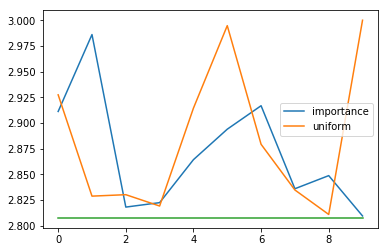

In [21]:
plt.plot(imp_err)
plt.plot(unif_err)
plt.plot(population_err*np.ones(len(imp_err)))
plt.legend(['importance','uniform'])